# Fine-tune LLM to follow instructions


## Load open weights

In [172]:
from gpt2_v2 import GPT2Model, GPT_CONFIG_124M, complete_text, generate_text_simple, tensor_to_text, text_to_tensor

GPT_CONFIG_124M.update({"qkv_bias": True})
model = GPT2Model(GPT_CONFIG_124M)


In [4]:
for name, param in model.named_parameters():
    print(name, param.shape)

tok_emb.weight torch.Size([50257, 768])
pos_emb.weight torch.Size([1024, 768])
blocks.0.attn.W_Q.weight torch.Size([768, 768])
blocks.0.attn.W_Q.bias torch.Size([768])
blocks.0.attn.W_K.weight torch.Size([768, 768])
blocks.0.attn.W_K.bias torch.Size([768])
blocks.0.attn.W_V.weight torch.Size([768, 768])
blocks.0.attn.W_V.bias torch.Size([768])
blocks.0.attn.out_proj.weight torch.Size([768, 768])
blocks.0.attn.out_proj.bias torch.Size([768])
blocks.0.ff.layers.0.weight torch.Size([3072, 768])
blocks.0.ff.layers.0.bias torch.Size([3072])
blocks.0.ff.layers.2.weight torch.Size([768, 3072])
blocks.0.ff.layers.2.bias torch.Size([768])
blocks.0.ln1.weight torch.Size([768])
blocks.0.ln1.bias torch.Size([768])
blocks.0.ln2.weight torch.Size([768])
blocks.0.ln2.bias torch.Size([768])
blocks.1.attn.W_Q.weight torch.Size([768, 768])
blocks.1.attn.W_Q.bias torch.Size([768])
blocks.1.attn.W_K.weight torch.Size([768, 768])
blocks.1.attn.W_K.bias torch.Size([768])
blocks.1.attn.W_V.weight torch.Size(

In [173]:
model.eval()
result = complete_text("at the start of", model,15)
print("Output text:\n", result)

Output text:
 at the start ofucc Matth Names sankleg sprayimize inflicting ShallUTC ))) spill Main insanely mph


### Download GPT2 from OpenAI

In [9]:
from tqdm import tqdm
import urllib
import os
import json
from urllib.parse import urljoin
import tensorflow as tf
import numpy as np

def download_file(url, destination, backup_url=None):
    def _attempt_download(download_url):
        with urllib.request.urlopen(download_url) as response:
            total_size = int(response.headers.get("Content-Length", 0))
            if os.path.exists(destination) and os.path.getsize(destination) == total_size:
                print(f"File already exists and is up-to-date: {destination}")
                return True

            with tqdm(total=total_size, unit="iB", unit_scale=True, desc=os.path.basename(download_url)) as pbar, \
                 open(destination, "wb") as f:
                for chunk in iter(lambda: response.read(1024), b""):
                    f.write(chunk)
                    pbar.update(len(chunk))
            return True

    try:
        if _attempt_download(url):
            return
    except (urllib.error.HTTPError, urllib.error.URLError):
        if backup_url:
            print(f"Primary URL failed. Trying backup URL: {backup_url}")
            try:
                if _attempt_download(backup_url):
                    return
            except (urllib.error.HTTPError, urllib.error.URLError):
                pass
        print(f"Failed to download from primary URL ({url})"
              + (f" and backup URL ({backup_url})" if backup_url else "") + ".\n"
              "Check your internet connection or the file availability.\n"
              "For help, visit: https://github.com/rasbt/LLMs-from-scratch/discussions/273")
    except Exception as e:
        print(f"Unexpected error: {e}")


def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    # Initialize parameters dictionary with empty blocks for each layer
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    # Iterate over each variable in the checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        # Load the variable and remove singleton dimensions
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        # Process the variable name to extract relevant parts
        variable_name_parts = name.split("/")[1:]  # Skip the 'model/' prefix

        # Identify the target dictionary for the variable
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        # Recursively access or create nested dictionaries
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        # Assign the variable array to the last key
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params


def download_and_load_gpt2(model_size, models_dir):
    allowed_sizes = {"124M", "355M", "774M", "1558M"}
    if model_size not in allowed_sizes:
        raise ValueError(f"Model size must be one of {allowed_sizes}")

    model_dir = os.path.join(models_dir, model_size)
    os.makedirs(model_dir, exist_ok=True)

    base_url = f"https://openaipublic.blob.core.windows.net/gpt-2/models/{model_size}/"
    backup_url = f"https://f001.backblazeb2.com/file/LLMs-from-scratch/gpt2/{model_size}/"

    filenames = [
        "checkpoint", "encoder.json", "hparams.json",
        "model.ckpt.data-00000-of-00001", "model.ckpt.index",
        "model.ckpt.meta", "vocab.bpe"
    ]

    for fname in filenames:
        dst = os.path.join(model_dir, fname)
        if os.path.exists(dst):
            print(f"Already exists: {fname}, skipping download.")
            continue
        primary = urljoin(base_url, fname)
        backup = urljoin(backup_url, fname)
        print(f"Downloading {fname} ...")
        download_file(primary, dst, backup)

    tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
    with open(os.path.join(model_dir, "hparams.json"), "r", encoding="utf-8") as f:
        settings = json.load(f)

    params = load_gpt2_params_from_tf_ckpt(tf_ckpt_path, settings)
    return settings, params


In [174]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")
print("Settings:", settings)
print("Params:", params.keys())

Already exists: checkpoint, skipping download.
Already exists: encoder.json, skipping download.
Already exists: hparams.json, skipping download.
Already exists: model.ckpt.data-00000-of-00001, skipping download.
Already exists: model.ckpt.index, skipping download.
Already exists: model.ckpt.meta, skipping download.
Already exists: vocab.bpe, skipping download.
Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Params: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [175]:
import torch
import numpy as np

def assign_(left, right):
    if right is None:
        raise ValueError("'right' cannot be None")
    right_tensor = torch.as_tensor(right, dtype=left.dtype, device=left.device)
    if right_tensor.numel() == 0:
        raise ValueError("'right' cannot be Empty")
    if left.shape != right_tensor.shape:
        raise ValueError(f"Shape mismatch: {left.shape} vs {right_tensor.shape}")
    with torch.no_grad():
        left.copy_(right_tensor)

def load_weights_into_gpt(gpt, params):
    assign_(gpt.pos_emb.weight, params["wpe"])
    assign_(gpt.tok_emb.weight, params["wte"])

    for b, (block, pblock) in enumerate(zip(gpt.blocks, params["blocks"])):
        # Attention QKV
        qw, kw, vw = np.split(pblock["attn"]["c_attn"]["w"], 3, axis=-1)
        qb, kb, vb = np.split(pblock["attn"]["c_attn"]["b"], 3, axis=-1)
        assign_(block.attn.W_Q.weight, qw.T)
        assign_(block.attn.W_K.weight, kw.T)
        assign_(block.attn.W_V.weight, vw.T)
        assign_(block.attn.W_Q.bias, qb)
        assign_(block.attn.W_K.bias, kb)
        assign_(block.attn.W_V.bias, vb)

        # Attention output projection
        assign_(block.attn.out_proj.weight, pblock["attn"]["c_proj"]["w"].T)
        assign_(block.attn.out_proj.bias,   pblock["attn"]["c_proj"]["b"])

        # Feedforward
        assign_(block.ff.layers[0].weight, pblock["mlp"]["c_fc"]["w"].T)
        assign_(block.ff.layers[0].bias,   pblock["mlp"]["c_fc"]["b"])
        assign_(block.ff.layers[2].weight, pblock["mlp"]["c_proj"]["w"].T)
        assign_(block.ff.layers[2].bias,   pblock["mlp"]["c_proj"]["b"])

        # LayerNorms
        assign_(block.ln1.weight, pblock["ln_1"]["g"])
        assign_(block.ln1.bias, pblock["ln_1"]["b"])
        assign_(block.ln2.weight, pblock["ln_2"]["g"])
        assign_(block.ln2.bias, pblock["ln_2"]["b"])

    assign_(gpt.final_norm.weight, params["g"])
    assign_(gpt.final_norm.bias, params["b"])
    assign_(gpt.out_head.weight,  params["wte"])


In [176]:
load_weights_into_gpt(model, params)
model.to("cpu")
model.eval()


GPT2Model(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_Q): Linear(in_features=768, out_features=768, bias=True)
        (W_K): Linear(in_features=768, out_features=768, bias=True)
        (W_V): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (ln1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlo

In [42]:
for name, param in model.named_parameters():
    print(name, param.shape, param.mean().item(), param.std().item())


tok_emb.weight torch.Size([50257, 768]) 0.00037981756031513214 0.14369554817676544
pos_emb.weight torch.Size([1024, 768]) -0.0006787165184505284 0.1226913258433342
blocks.0.attn.W_Q.weight torch.Size([768, 768]) 0.00015374351642094553 0.2386905699968338
blocks.0.attn.W_Q.bias torch.Size([768]) -0.007821076549589634 0.3427544832229614
blocks.0.attn.W_K.weight torch.Size([768, 768]) 1.2351122677500825e-05 0.2432965785264969
blocks.0.attn.W_K.bias torch.Size([768]) 0.0048723239451646805 0.18297071754932404
blocks.0.attn.W_V.weight torch.Size([768, 768]) -5.968316145299468e-06 0.05811797454953194
blocks.0.attn.W_V.bias torch.Size([768]) 0.0008267878438346088 0.04772818833589554
blocks.0.attn.out_proj.weight torch.Size([768, 768]) -0.0001613790518604219 0.1474614143371582
blocks.0.attn.out_proj.bias torch.Size([768]) -0.00691022165119648 0.2589662969112396
blocks.0.ff.layers.0.weight torch.Size([3072, 768]) -0.0007485305541194975 0.14116929471492767
blocks.0.ff.layers.0.bias torch.Size([307

In [94]:
from gpt2_v2 import complete_text
result = complete_text("at the start of", model,15)
print("Output text:\n", result)

Output text:
 at the start of the game, and then the game ends.

The game is a


In [177]:
import tiktoken

torch.manual_seed(123)
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_tensor("at the start of", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", tensor_to_text(token_ids, tokenizer))

Output text:
 at the start of an international series of events. You don't have to worry about who has


## Instruction Finetuning

In [103]:
!wget https://raw.githubusercontent.com/tatsu-lab/stanford_alpaca/main/alpaca_data.json


--2025-06-15 15:16:07--  https://raw.githubusercontent.com/tatsu-lab/stanford_alpaca/main/alpaca_data.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 30.100.0.25, 30.100.0.26, 30.100.0.23, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|30.100.0.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22773992 (22M) [text/plain]
Saving to: ‘alpaca_data.json’

alpaca_data.json    100%[===================>]  21.72M  21.9MB/s    in 1.0s    

2025-06-15 15:16:10 (21.9 MB/s) - ‘alpaca_data.json’ saved [22773992/22773992]



In [242]:
import json
import random

with open("alpaca_data.json", "r") as f:
    data = json.load(f)

random.seed(123)
data = random.sample(data, 1000)


In [243]:
def format_input(entry):
    instruction = entry.get("instruction", "").strip()
    input_section = entry.get("input", "").strip()

    parts = [
        "Below is an instruction that describes a task. Write a response that appropriately completes the request.",
        "\n\n### Instruction:\n" + instruction,
    ]

    if input_section:
        parts.append("\n\n### Input:\n" + input_section)

    return "".join(parts)


In [245]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Generate a general statement about the importance of empathy.

### Response:
Empathy is essential for fostering meaningful relationships, deepening understanding between people, and building a more compassionate world.


In [248]:
n = len(data)
train_data = data[:int(n * 0.80)]
test_data = data[int(n * 0.80):int(n * 0.90)]
val_data = data[int(n * 0.90):]

In [249]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 800
Validation set length: 100
Test set length: 100


In [250]:
print(len(train_dataset))
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

850
Train loader:
torch.Size([8, 110]) torch.Size([8, 110])
torch.Size([8, 146]) torch.Size([8, 146])
torch.Size([8, 141]) torch.Size([8, 141])
torch.Size([8, 147]) torch.Size([8, 147])
torch.Size([8, 107]) torch.Size([8, 107])
torch.Size([8, 249]) torch.Size([8, 249])
torch.Size([8, 231]) torch.Size([8, 231])
torch.Size([8, 199]) torch.Size([8, 199])
torch.Size([8, 185]) torch.Size([8, 185])
torch.Size([8, 130]) torch.Size([8, 130])
torch.Size([8, 180]) torch.Size([8, 180])
torch.Size([8, 147]) torch.Size([8, 147])
torch.Size([8, 259]) torch.Size([8, 259])
torch.Size([8, 109]) torch.Size([8, 109])
torch.Size([8, 201]) torch.Size([8, 201])
torch.Size([8, 199]) torch.Size([8, 199])
torch.Size([8, 201]) torch.Size([8, 201])
torch.Size([8, 307]) torch.Size([8, 307])
torch.Size([8, 158]) torch.Size([8, 158])
torch.Size([8, 191]) torch.Size([8, 191])
torch.Size([8, 155]) torch.Size([8, 155])
torch.Size([8, 292]) torch.Size([8, 292])
torch.Size([8, 111]) torch.Size([8, 111])
torch.Size([8, 1

In [131]:
import torch
from torch.utils.data import Dataset
from functools import partial

device = "cpu"  # or "cuda" if available

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.encoded_texts = [
            tokenizer.encode(
                format_input(entry) + f"\n\n### Response:\n{entry['output']}"
            )
            for entry in data
        ]

    def __len__(self):
        return len(self.encoded_texts)

    def __getitem__(self, idx):
        return self.encoded_texts[idx]


def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    max_len = min(
        max(len(seq) + 1 for seq in batch),
        allowed_max_length or float('inf')
    )

    input_tensors, label_tensors = [], []

    for seq in batch:
        seq = seq + [pad_token_id]
        padded = seq + [pad_token_id] * (max_len - len(seq))

        inputs = torch.tensor(padded[:-1], dtype=torch.long)
        labels = torch.tensor(padded[1:], dtype=torch.long)

        # Mask padding in labels except the first one
        pad_mask = (labels == pad_token_id).nonzero(as_tuple=True)[0]
        if len(pad_mask) > 1:
            labels[pad_mask[1:]] = ignore_index

        input_tensors.append(inputs)
        label_tensors.append(labels)

    return (
        torch.stack(input_tensors).to(device),
        torch.stack(label_tensors).to(device)
    )


customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)


In [251]:
from torch.utils.data import DataLoader

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=8, collate_fn=customized_collate_fn, shuffle=True,drop_last=True,num_workers=0)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(val_dataset, batch_size=8, collate_fn=customized_collate_fn, shuffle=False,drop_last=False,num_workers=0)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=8, collate_fn=customized_collate_fn, shuffle=False,drop_last=False,num_workers=0)

In [252]:
print("train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)
print("inputs: ",inputs[0])
print("targets: ",targets[0])

train loader:
torch.Size([8, 218]) torch.Size([8, 218])
torch.Size([8, 110]) torch.Size([8, 110])
torch.Size([8, 166]) torch.Size([8, 166])
torch.Size([8, 174]) torch.Size([8, 174])
torch.Size([8, 135]) torch.Size([8, 135])
torch.Size([8, 457]) torch.Size([8, 457])
torch.Size([8, 125]) torch.Size([8, 125])
torch.Size([8, 119]) torch.Size([8, 119])
torch.Size([8, 157]) torch.Size([8, 157])
torch.Size([8, 167]) torch.Size([8, 167])
torch.Size([8, 169]) torch.Size([8, 169])
torch.Size([8, 96]) torch.Size([8, 96])
torch.Size([8, 191]) torch.Size([8, 191])
torch.Size([8, 158]) torch.Size([8, 158])
torch.Size([8, 196]) torch.Size([8, 196])
torch.Size([8, 239]) torch.Size([8, 239])
torch.Size([8, 147]) torch.Size([8, 147])
torch.Size([8, 116]) torch.Size([8, 116])
torch.Size([8, 180]) torch.Size([8, 180])
torch.Size([8, 210]) torch.Size([8, 210])
torch.Size([8, 200]) torch.Size([8, 200])
torch.Size([8, 171]) torch.Size([8, 171])
torch.Size([8, 219]) torch.Size([8, 219])
torch.Size([8, 264]) t

In [253]:
model.eval()
torch.manual_seed(123)

input_text = format_input(val_data[0])
token_ids = generate_text_simple(
    model=model,
    idx=text_to_tensor(input_text, tokenizer),
    max_new_tokens=35,
    context_size=1024,
    eos_id=50256,
)
generated_text = tensor_to_text(token_ids, tokenizer)
print(generated_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Analyze the text below, and interpret the message it implies.

### Input:
The world is increasingly becoming a dangerous place to live.

### Response:
The text below suggests that the world is increasingly becoming a dangerous place to live.


In [254]:
from gpt2_v2 import loss_loader

model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = loss_loader(train_loader, model, device, num_batches=5)
    val_loss = loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 1.8374699354171753
Validation loss: 1.7696917057037354


### Train as normal

In [256]:
import torch
import time
from gpt2_v2 import train_model_simple, build_tokenizer

torch.manual_seed(123)
torch.set_num_threads(12)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

start_time = time.time()

# FineTune the model
num_epochs = 2
train_losses, val_losses, tokens_seen = train_model_simple(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context=format_input(val_data[0]),
    tokenizer=build_tokenizer()
)

elapsed = (time.time() - start_time) / 60
print(f"Training completed in {elapsed:.2f} minutes.")


Ep 1 (Step 000005): Train loss 1.881, Val loss 1.806, Tokens seen: 6424
Ep 1 (Step 000010): Train loss 1.843, Val loss 1.783, Tokens seen: 14624
Ep 1 (Step 000015): Train loss 1.842, Val loss 1.784, Tokens seen: 21104
Ep 1 (Step 000020): Train loss 1.870, Val loss 1.774, Tokens seen: 28240
Ep 1 (Step 000025): Train loss 1.803, Val loss 1.773, Tokens seen: 36288
Ep 1 (Step 000030): Train loss 1.593, Val loss 1.763, Tokens seen: 44584
Ep 1 (Step 000035): Train loss 1.754, Val loss 1.755, Tokens seen: 53184
Ep 1 (Step 000040): Train loss 1.704, Val loss 1.769, Tokens seen: 60104
Ep 1 (Step 000045): Train loss 1.851, Val loss 1.754, Tokens seen: 72128
Ep 1 (Step 000050): Train loss 1.683, Val loss 1.744, Tokens seen: 81440
Ep 1 (Step 000055): Train loss 1.643, Val loss 1.757, Tokens seen: 88864
Ep 1 (Step 000060): Train loss 1.712, Val loss 1.750, Tokens seen: 97120
Ep 1 (Step 000065): Train loss 1.679, Val loss 1.739, Tokens seen: 104936
Ep 1 (Step 000070): Train loss 1.693, Val loss 1.74

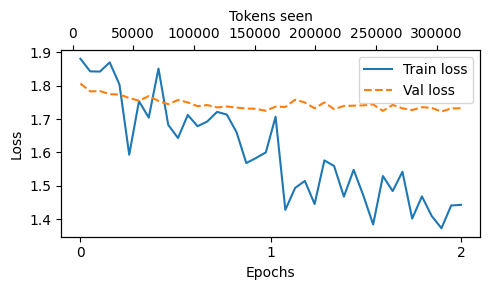

In [257]:
from gpt2_v2 import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [221]:
model.eval()
torch.manual_seed(123)

input_text = format_input(val_data[1])
token_ids = generate_text_simple(
    model=model,
    idx=text_to_tensor(input_text, tokenizer),
    max_new_tokens=35,
    context_size=1024,
    eos_id=50256,
)
generated_text = tensor_to_text(token_ids, tokenizer)
print(generated_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Propose a suitable title for the below article

### Input:
This article discusses the current state of the music industry and how technology has had an impact on its evolution.

### Response:
The current state of the music industry and how technology has had an impact on its evolution is described in the article.


## Save model

In [222]:
from tqdm import tqdm
import json

def generate_response(entry, model):
    input_text = format_input(entry)
    token_ids = generate_text_simple(
        model=model,
        idx=text_to_tensor(input_text, tokenizer),
        max_new_tokens=35,
        context_size=1024,
        eos_id=50256,
    )
    generated_text = tensor_to_text(token_ids, tokenizer)
    response = generated_text[len(input_text):].replace("### Response:", "").strip()
    return response

# Generate and attach responses
for entry in tqdm(test_data, desc="Generating responses"):
    entry["model_response"] = generate_response(entry, model)

# Save to file
with open("instruction-data-with-response.json", "w") as f:
    json.dump(test_data, f, indent=4)


Generating responses: 100%|██████████| 100/100 [02:03<00:00,  1.24s/it]


In [228]:
print(test_data[0])

{'instruction': 'Design a logo for a child care center.', 'input': '', 'output': 'The logo should be warm, playful and inviting. It should utilize a font that is easy to read and appealing to children. I would suggest a combination of vibrant colors, such as yellow, blue and green. It could include an image of a happy kid or an illustration of a sun and clouds. The logo should also convey a sense of security and safety, as the center is aiming to provide a safe, nurturing environment for kids.', 'model_response': 'The logo should be simple and simple, with a simple design and a simple message. It should be simple and simple, with a simple message and'}


In [258]:
file_name = "gpt2-124M-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-124M-sft.pth


## Evaluate the model

In [262]:
import psutil

def is_process_running(name_substr: str) -> bool:
    """Check if any running process contains the given substring in its name."""
    return any(name_substr.lower() in (proc.info["name"] or "").lower()
               for proc in psutil.process_iter(["name"]))

if not is_process_running("ollama"):
    raise RuntimeError("❌ Ollama not running. Please launch it before proceeding.")

print("✅ Ollama is running.")


✅ Ollama is running.


In [233]:
import json
import urllib.request

def query_model(
    prompt: str,
    model: str = "llama3",
    url: str = "http://localhost:11434/api/chat",
    seed: int = 123,
    temperature: float = 0.0,
    num_ctx: int = 2048
) -> str:
    """Send a prompt to a local chat model and return the generated response."""

    data = {
        "model": model,
        "messages": [{"role": "user", "content": prompt}],
        "options": {
            "seed": seed,
            "temperature": temperature,
            "num_ctx": num_ctx
        }
    }

    request = urllib.request.Request(
        url,
        data=json.dumps(data).encode("utf-8"),
        method="POST",
        headers={"Content-Type": "application/json"}
    )

    response_text = []

    try:
        with urllib.request.urlopen(request) as response:
            for line in response:
                line = line.decode("utf-8").strip()
                if line:
                    message_chunk = json.loads(line)
                    content = message_chunk.get("message", {}).get("content", "")
                    response_text.append(content)
    except Exception as e:
        raise RuntimeError(f"Failed to query model: {e}")

    return "".join(response_text)


In [234]:
result = query_model("What do Llamas eat?", "llama3")
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy the sweet taste and texture of fresh hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their daily ration. However, it's essential to provide these grains in moderation, as they can be high in calories.
4. Fruits and vegetables: Llamas enjoy a variety of fruits and veggies, such as apples, carrots, sweet potatoes, and leafy greens like kale or spinach.
5. Minerals: Llamas require access to mineral supplements, which help maintain their overall health and well-being.

In the wild, llamas might also eat:

1. Leaves: They'll munch on leaves from trees and shrubs, including plants like willow, alder, and birch.
2. Bark: In some cases, ll

In [238]:
from tqdm import tqdm

def generate_model_scores(data, response_key="model_response", model="llama3"):
    """Generate integer scores (0–100) for model responses using LLM evaluation."""
    scores = []

    for entry in tqdm(data, desc="Scoring entries"):
        prompt = (
            "Given the input below, the correct output, and the model's response, "
            "score the model's response on a scale from 0 to 100, where 100 is the best.\n\n"
            f"### Input:\n{format_input(entry)}\n\n"
            f"### Expected Output:\n{entry['output']}\n\n"
            f"### Model Response:\n{entry.get(response_key, '').strip()}\n\n"
            "### Respond with the integer number only."
        )

        try:
            score_str = query_model(prompt, model=model).strip()
            score = int(score_str)
            scores.append(score)
        except ValueError:
            print(f"[Warning] Invalid score format: {score_str!r}")
        except Exception as e:
            print(f"[Error] Scoring failed for entry: {e}")

    return scores


In [263]:
scores = generate_model_scores(test_data)
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average: {sum(scores)/len(scores):.2f}, Max: {max(scores)}, Min: {min(scores)}")

Scoring entries:   6%|▌         | 6/100 [00:12<02:31,  1.62s/it]

[Warning] Invalid score format: 'I\'d score the model\'s response as 0 out of 100. The reason is that the model did not provide a complete and accurate response. It simply left a blank space without providing any information about the United Nations or its establishment date.\n\nA good response would have included the correct answer, which is "The United Nations was established in 1945, 75 years ago."'


Scoring entries:   8%|▊         | 8/100 [00:14<01:49,  1.19s/it]

[Warning] Invalid score format: "I'd score the model's response as 0 out of 100, since it didn't provide any output at all!"


Scoring entries:  10%|█         | 10/100 [00:16<01:58,  1.32s/it]

[Warning] Invalid score format: "I'd score the model's response a 0 out of 100.\n\nThe model didn't provide any output at all, which is not acceptable for this task. The expected output includes specific categories and amounts that are relevant to the input expenses, but the model failed to generate anything resembling the expected output."


Scoring entries:  15%|█▌        | 15/100 [00:21<02:02,  1.44s/it]

[Warning] Invalid score format: "I'd score the model's response as 0 out of 100. Here's why:\n\n* The instruction asks for a specific answer, but the model simply leaves the response blank.\n* The expected output provides a clear and concise answer to the question, which is not reflected in the model's response.\n\nTo achieve a higher score, the model should provide an accurate and relevant response that completes the request. In this case, the model failed to do so, resulting in a score of 0."


Scoring entries:  20%|██        | 20/100 [00:25<01:23,  1.04s/it]

[Warning] Invalid score format: "I'd score the model's response as 0/100. The reason is that the model did not provide any response at all, whereas the task was to explain why the output is not accurate (which implies that there should be some kind of analysis or critique)."


Scoring entries:  21%|██        | 21/100 [00:27<01:50,  1.40s/it]

[Warning] Invalid score format: 'I\'d score the model\'s response as 0/100.\n\nThe reason is that the model didn\'t provide any response at all, which means it failed to complete the task described in the instruction. The expected output was clearly specified as "7, 9", but the model didn\'t even attempt to generate a response.'


Scoring entries:  26%|██▌       | 26/100 [00:30<01:10,  1.06it/s]

[Warning] Invalid score format: "I'd score the model's response as 0/100 because it didn't provide any output at all! A complete response would be expected to include the type of quadrilateral formed by the given points, which is a rectangle in this case."


Scoring entries:  27%|██▋       | 27/100 [00:32<01:33,  1.29s/it]

[Warning] Invalid score format: "I'd score the model's response as 0 out of 100.\n\nThe reason is that the model didn't provide any output at all, whereas the expected output was a specific area code (51) for the given ZIP code (74321). The model failed to complete the task and provide an answer."


Scoring entries:  33%|███▎      | 33/100 [00:36<01:02,  1.07it/s]

[Warning] Invalid score format: "I'd score the model's response as 0/100, since it doesn't provide a data visualization at all. The expected output is a simple bar chart showing the temperature of three cities, but the model simply left the space blank."


Scoring entries:  40%|████      | 40/100 [00:41<01:11,  1.20s/it]

[Warning] Invalid score format: "I would score the model's response as 20 out of 100.\n\nThe model failed to provide a chart or any relevant information about the employment rate in the US from 2019 to 2020, which is the main requirement of the task. The expected output clearly shows a table with the employment rates for each year, but the model's response does not meet this expectation at all."


Scoring entries:  67%|██████▋   | 67/100 [00:53<00:29,  1.11it/s]

[Warning] Invalid score format: 'I\'d score the model\'s response a 0 out of 100 because it doesn\'t provide any information about the BPM of the song "Fading Away" by Jaws of Love, which is the expected output. The model simply leaves the response blank, failing to complete the task as instructed.'


Scoring entries:  76%|███████▌  | 76/100 [01:00<00:27,  1.16s/it]

[Warning] Invalid score format: "I'd score the model's response as 0 out of 100. The reason is that the model did not provide any response at all, which means it failed to complete the task as instructed. A correct response would have calculated the area of the circle using the formula A = πr² and provided the result, which is 12.57m2 in this case."


Scoring entries:  83%|████████▎ | 83/100 [01:04<00:15,  1.08it/s]

[Warning] Invalid score format: "I'd score the model's response as 0 out of 100. The expected output is a clear and concise answer that provides both possibilities for generating random numbers using a computer, whereas the model's response is blank, indicating no attempt to provide an answer."


Scoring entries:  86%|████████▌ | 86/100 [01:08<00:19,  1.39s/it]

[Warning] Invalid score format: "I'd score the model's response as 0 out of 100. The reason is that the model simply copied the current trading price, which doesn't take into account any potential changes or fluctuations in the stock market throughout the day. A good predictive model should consider various factors and make an educated estimate based on historical data and trends. In this case, the model's response lacks any meaningful analysis or prediction, making it a poor attempt at completing the task."


Scoring entries:  87%|████████▋ | 87/100 [01:09<00:16,  1.27s/it]

[Warning] Invalid score format: "I'd score the model's response as 0 out of 100, since it didn't provide any output at all!"


Scoring entries: 100%|██████████| 100/100 [01:14<00:00,  1.34it/s]

Number of scores: 85 of 100
Average: 56.62, Max: 85, Min: 0
